In [1]:
from google.cloud import firestore

db = firestore.AsyncClient(
    project='tg-bot-clotheoff-prod', # 'tg-bot-clotheoff-prod', 
    database='undress-tg-bot-prod', # 'undress-tg-bot-prod', 
)

# logger.info("Performing Firestore connection check...")
test_query = db.collection('users').limit(1)

Попытка подключения к Firestore...
✓ Успешное подключение к проекту 'tg-bot-clotheoff-prod' и базе данных 'undress-tg-bot-prod'.

1. Ищем пользователей из кампании 'salfetka_06_27'...


e:\py_projects\tg_bot\venv\Lib\site-packages\google\cloud\firestore_v1\base_collection.py:303: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


✓ Найдено пользователей: 1188

2. Собираем события для найденных пользователей...
✓ Собрано релевантных событий: 1053

3. Анализируем воронку и считаем конверсии...

--- Отчет по воронке для кампании 'salfetka_06_27' ---

1. Всего пришло пользователей:
   1188

2. Дошли до просмотра оффера (событие: 'payment_package_selected'):
   165 пользователей

3. Попытались сгенерировать (события: generation_attempt_insufficient_balance, generation_requested):
   687 пользователей

4. Оплатили (событие: 'payment_successful'):
   6 пользователей

--------------------------------------------------
--- Конверсии ---
--------------------------------------------------

  - CR1 (из регистрации в просмотр оффера): 13.89%
  - CR2 (из просмотра оффера в оплату): 3.64%
  - Общая конверсия (из регистрации в оплату): 0.51%


4. Готовим график регистрации пользователей (с детализацией по минутам)...
✓ График готов. Показываю...


C:\Users\igorl\AppData\Local\Temp\ipykernel_12780\9992664.py:134: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_users['registration_minute'] = df_users['created_at'].dt.floor('T')


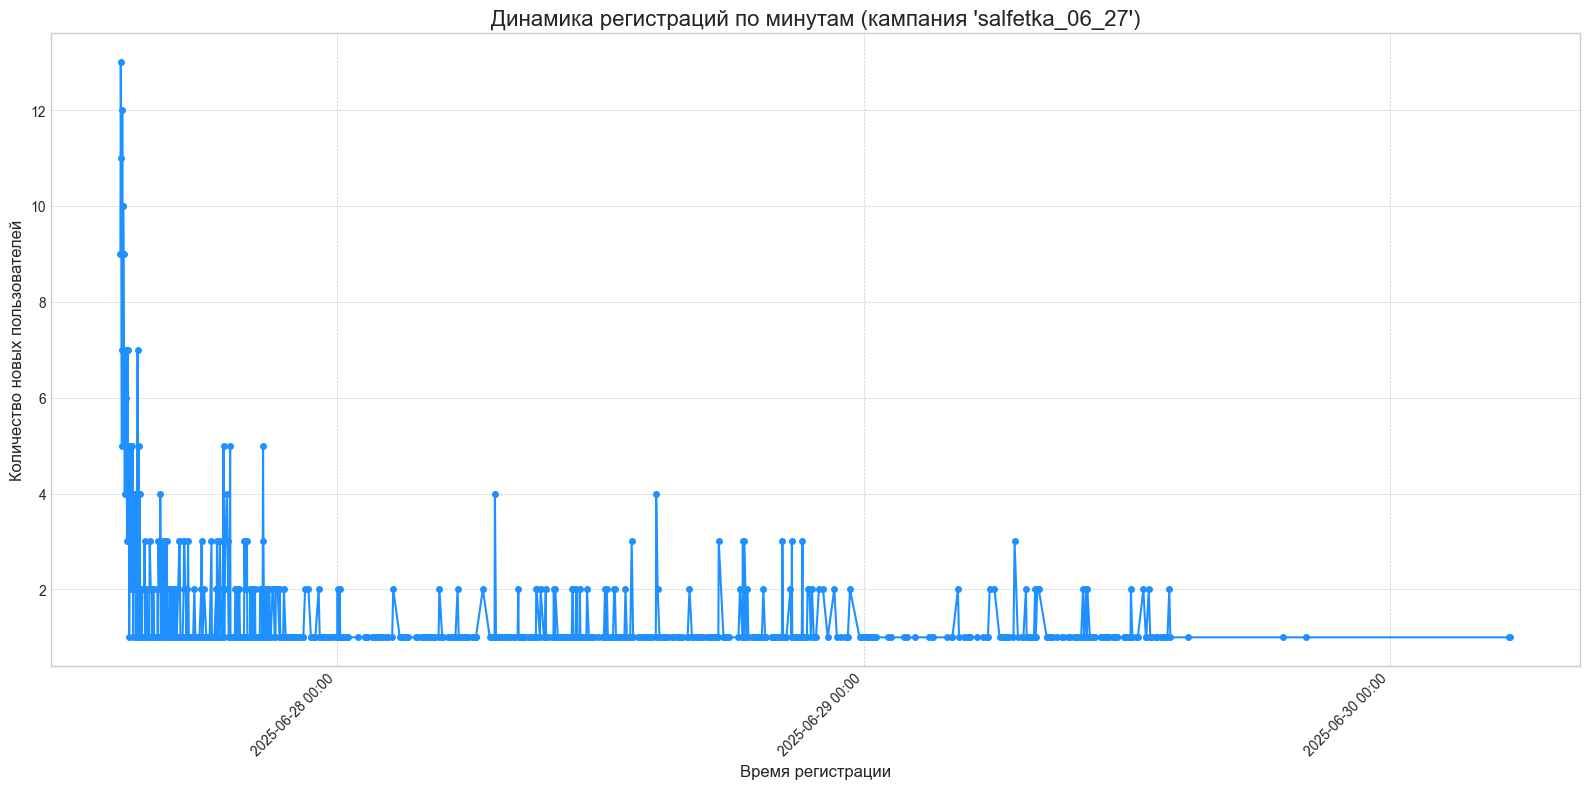

In [2]:
import os
from google.cloud import firestore
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- НАСТРОЙКИ: ЗАПОЛНИТЕ ВАШИ ДАННЫЕ ЗДЕСЬ ---

# 1. ID вашего проекта в Google Cloud (например, 'tg-bot-clotheoff-prod')
GCP_PROJECT_ID = 'tg-bot-clotheoff-prod' 

# 2. Имя вашей базы данных Firestore (например, 'undress-tg-bot-prod')
# Если вы используете базу данных по умолчанию, это значение должно быть '(default)'
FIRESTORE_DB_NAME = 'undress-tg-bot-prod' 

# 3. Название вашей рекламной кампании
TARGET_SOURCE = "salfetka_06_27"

# Определяем типы событий для каждого этапа воронки
EVENT_VIEW_OFFER = 'payment_package_selected'
EVENT_PAYMENT_SUCCESS = 'payment_successful'
EVENTS_GENERATION_ATTEMPT = {
    'generation_requested', 
    'generation_attempt_insufficient_balance'
}

# --- Инициализация клиента Firestore ---
print("Попытка подключения к Firestore...")
try:
    db = firestore.Client(project=GCP_PROJECT_ID, database=FIRESTORE_DB_NAME)
    check_conn = db.collection('users').limit(1).stream()
    next(check_conn, None)
    print(f"✓ Успешное подключение к проекту '{GCP_PROJECT_ID}' и базе данных '{FIRESTORE_DB_NAME}'.")
except Exception as e:
    print(f"✗ Ошибка подключения к Firestore. Проверьте настройки и аутентификацию ('gcloud auth application-default login').")
    print(f"  Детали ошибки: {e}")
    exit()

# --- ШАГ 1: Получение пользователей из целевой рекламной кампании ---
print(f"\n1. Ищем пользователей из кампании '{TARGET_SOURCE}'...")
users_ref = db.collection('users')
query = users_ref.where('source', '==', TARGET_SOURCE)
docs = query.stream()

campaign_users_data = []
for doc in docs:
    user = doc.to_dict()
    campaign_users_data.append({
        'user_id': user.get('user_id'),
        'created_at': user.get('created_at')
    })
    
if not campaign_users_data:
    print(f"Не найдено ни одного пользователя из кампании '{TARGET_SOURCE}'. Проверьте название.")
    exit()

print(f"✓ Найдено пользователей: {len(campaign_users_data)}")
campaign_user_ids = {user['user_id'] for user in campaign_users_data}

# --- ШАГ 2: Сбор всех событий для этих пользователей ---
print("\n2. Собираем события для найденных пользователей...")
events_ref = db.collection('user_events')
all_events = events_ref.stream()

campaign_events = []
for event_doc in all_events:
    event_data = event_doc.to_dict()
    user_id = event_data.get('user_id')
    
    if user_id in campaign_user_ids:
        # ### --- КЛЮЧЕВОЕ ИЗМЕНЕНИЕ ЗДЕСЬ --- ###
        # Получаем event_type напрямую из документа, а не из event_details
        event_type = event_data.get('event_type')
        
        if event_type:
            campaign_events.append({
                'user_id': user_id,
                'event_type': event_type
            })

print(f"✓ Собрано релевантных событий: {len(campaign_events)}")

# --- ШАГ 3: Анализ воронки и расчет конверсий ---
# (Этот блок остается без изменений, он уже работает правильно)
print("\n3. Анализируем воронку и считаем конверсии...")
users_in_funnel = {
    'total': campaign_user_ids,
    'viewed_offer': set(),
    'attempted_generation': set(),
    'paid': set()
}

for event in campaign_events:
    user_id = event['user_id']
    event_type = event['event_type']

    if event_type == EVENT_VIEW_OFFER:
        users_in_funnel['viewed_offer'].add(user_id)
    if event_type in EVENTS_GENERATION_ATTEMPT:
        users_in_funnel['attempted_generation'].add(user_id)
    if event_type == EVENT_PAYMENT_SUCCESS:
        users_in_funnel['paid'].add(user_id)

count_total = len(users_in_funnel['total'])
count_viewed_offer = len(users_in_funnel['viewed_offer'])
count_attempted_generation = len(users_in_funnel['attempted_generation'])
count_paid = len(users_in_funnel['paid'])

conv_to_offer_view = (count_viewed_offer / count_total * 100) if count_total > 0 else 0
conv_from_offer_to_payment = (count_paid / count_viewed_offer * 100) if count_viewed_offer > 0 else 0
conv_total_to_payment = (count_paid / count_total * 100) if count_total > 0 else 0

# --- Вывод результатов ---
print("\n" + "="*50)
print(f"--- Отчет по воронке для кампании '{TARGET_SOURCE}' ---")
print("="*50 + "\n")
print(f"1. Всего пришло пользователей:\n   {count_total}\n")
print(f"2. Дошли до просмотра оффера (событие: '{EVENT_VIEW_OFFER}'):\n   {count_viewed_offer} пользователей\n")
print(f"3. Попытались сгенерировать (события: {', '.join(EVENTS_GENERATION_ATTEMPT)}):\n   {count_attempted_generation} пользователей\n")
print(f"4. Оплатили (событие: '{EVENT_PAYMENT_SUCCESS}'):\n   {count_paid} пользователей\n")
print("-" * 50)
print("--- Конверсии ---")
print("-" * 50 + "\n")
print(f"  - CR1 (из регистрации в просмотр оффера): {conv_to_offer_view:.2f}%")
print(f"  - CR2 (из просмотра оффера в оплату): {conv_from_offer_to_payment:.2f}%")
print(f"  - Общая конверсия (из регистрации в оплату): {conv_total_to_payment:.2f}%")
print("\n" + "="*50)


# --- ШАГ 4: Визуализация прихода новых пользователей (по минутам) ---
print("\n4. Готовим график регистрации пользователей (с детализацией по минутам)...")
df_users = pd.DataFrame(campaign_users_data)
df_users['created_at'] = pd.to_datetime(df_users['created_at'])
df_users['registration_minute'] = df_users['created_at'].dt.floor('T')
minute_registrations = df_users.groupby('registration_minute').size()

if minute_registrations.empty:
    print("Недостаточно данных для построения графика по минутам.")
else:
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 8))
    minute_registrations.plot(kind='line', ax=ax, color='dodgerblue', marker='o', linestyle='-', ms=4)
    ax.set_title(f"Динамика регистраций по минутам (кампания '{TARGET_SOURCE}')", fontsize=16)
    ax.set_xlabel("Время регистрации", fontsize=12)
    ax.set_ylabel("Количество новых пользователей", fontsize=12)
    ax.grid(True, which='major', linestyle='--', linewidth=0.5)
    formatter = mdates.DateFormatter('%Y-%m-%d %H:%M')
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=12))
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    print("✓ График готов. Показываю...")
    plt.show()

In [7]:
a = []
for event in campaign_events:
    user_id = event['user_id']
    event_type = event['event_type']

    
    if event_type in ['generation_requested']:
        a.append(user_id)

print(set(a))
    

{6444943650, 1707199753, 1384997898, 5094173429, 5810366328, 827234586}


In [3]:
print("\n" + "="*50)
print(f"--- Отчет по воронке для кампании '{TARGET_SOURCE}' ---")
print("="*50 + "\n")
print(f"1. Всего пришло пользователей:\n   {count_total}\n")
print(f"2. Дошли до просмотра оффера (событие: '{EVENT_VIEW_OFFER}'):\n   {count_viewed_offer} пользователей\n")
print(f"3. Попытались сгенерировать (события: {', '.join(EVENTS_GENERATION_ATTEMPT)}):\n   {count_attempted_generation} пользователей\n")
print(f"4. Оплатили (событие: '{EVENT_PAYMENT_SUCCESS}'):\n   {count_paid} пользователей\n")
print("-" * 50)
print("--- Конверсии ---")
print("-" * 50 + "\n")
print(f"  - CR1 (из регистрации в просмотр оффера): {conv_to_offer_view:.2f}%")
print(f"  - CR2 (из просмотра оффера в оплату): {conv_from_offer_to_payment:.2f}%")
print(f"  - Общая конверсия (из регистрации в оплату): {conv_total_to_payment:.2f}%")
print("\n" + "="*50)


--- Отчет по воронке для кампании 'salfetka_06_27' ---

1. Всего пришло пользователей:
   1188

2. Дошли до просмотра оффера (событие: 'payment_package_selected'):
   165 пользователей

3. Попытались сгенерировать (события: generation_attempt_insufficient_balance, generation_requested):
   687 пользователей

4. Оплатили (событие: 'payment_successful'):
   6 пользователей

--------------------------------------------------
--- Конверсии ---
--------------------------------------------------

  - CR1 (из регистрации в просмотр оффера): 13.89%
  - CR2 (из просмотра оффера в оплату): 3.64%
  - Общая конверсия (из регистрации в оплату): 0.51%




5. Готовим комбинированный график регистраций и оплат...
   - Собираем события с временными метками...
   ✓ Собрано релевантных событий: 1053

   - Строим график...
✓ Комбинированный график готов. Показываю...


C:\Users\igorl\AppData\Local\Temp\ipykernel_12780\3475553121.py:38: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_users['registration_hour'] = df_users['created_at'].dt.floor('H')


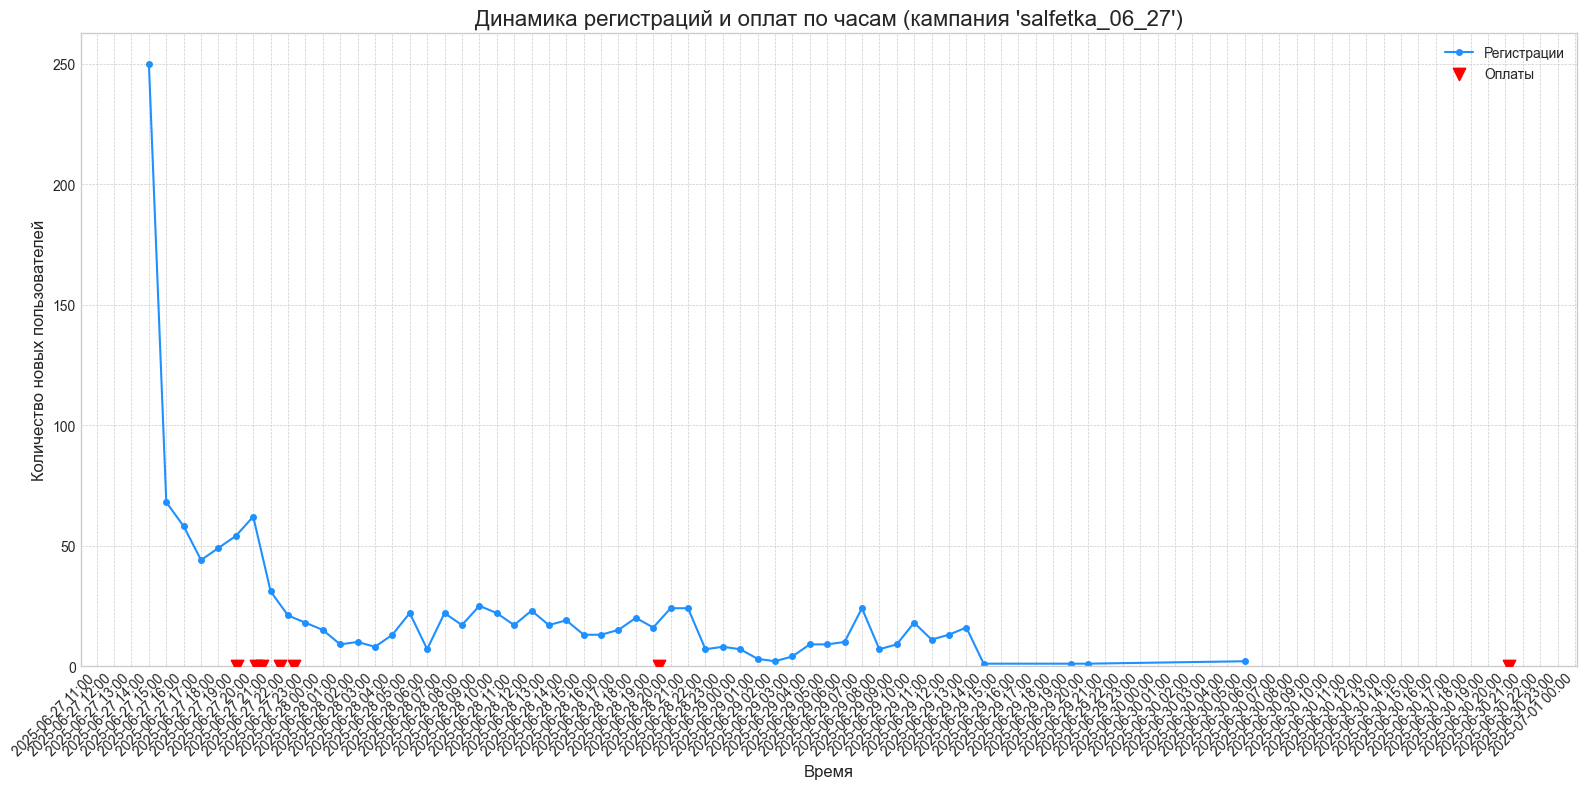

In [4]:
print("\n5. Готовим комбинированный график регистраций и оплат...")

# --- 5.1: Сбор событий с временными метками ---
# Примечание: мы заново собираем события, чтобы получить временные метки, 
# не изменяя код в предыдущих ячейках.
print("   - Собираем события с временными метками...")
events_ref = db.collection('user_events')
all_events_with_ts = events_ref.stream()

campaign_events_with_ts = []
for event_doc in all_events_with_ts:
    event_data = event_doc.to_dict()
    user_id = event_data.get('user_id')
    
    if user_id in campaign_user_ids: # Используем campaign_user_ids из Шага 1
        event_type = event_data.get('event_type')
        event_timestamp = event_data.get('timestamp')
        
        if event_type and event_timestamp:
            campaign_events_with_ts.append({
                'user_id': user_id,
                'event_type': event_type,
                'timestamp': pd.to_datetime(event_timestamp)
            })
print(f"   ✓ Собрано релевантных событий: {len(campaign_events_with_ts)}")

# --- 5.2: Подготовка данных для графика (АГРЕГАЦИЯ ПО ЧАСАМ) ---
df_payments = pd.DataFrame([
    {'timestamp': event['timestamp']}
    for event in campaign_events_with_ts
    if event['event_type'] == EVENT_PAYMENT_SUCCESS
])

# Данные о регистрациях берем из переменной campaign_users_data (из Шага 1)
df_users = pd.DataFrame(campaign_users_data)
df_users['created_at'] = pd.to_datetime(df_users['created_at'])
# --- ИЗМЕНЕНИЕ: Группируем по часам, а не по минутам ---
df_users['registration_hour'] = df_users['created_at'].dt.floor('H')
hour_registrations = df_users.groupby('registration_hour').size()

# --- 5.3: Построение графика ---
if hour_registrations.empty and df_payments.empty:
    print("\nНедостаточно данных для построения графика.")
else:
    print("\n   - Строим график...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # График регистраций (по часам)
    if not hour_registrations.empty:
        hour_registrations.plot(kind='line', ax=ax, color='dodgerblue', marker='o', linestyle='-', ms=4, label='Регистрации')

    # Маркеры оплат
    if not df_payments.empty:
        # Рисуем маркеры оплат на уровне Y=0.2, чтобы они были хорошо видны под основной линией
        y_value_for_payments = 0.2
        ax.scatter(df_payments['timestamp'], [y_value_for_payments] * len(df_payments),
                   color='red', marker='v', s=80, label='Оплаты', zorder=5)

    ax.set_title(f"Динамика регистраций и оплат по часам (кампания '{TARGET_SOURCE}')", fontsize=16)
    ax.set_xlabel("Время", fontsize=12)
    ax.set_ylabel("Количество новых пользователей", fontsize=12)
    ax.grid(True, which='major', linestyle='--', linewidth=0.5)

    ax.set_ylim(bottom=0) 
    
    formatter = mdates.DateFormatter('%Y-%m-%d %H:%M')
    ax.xaxis.set_major_formatter(formatter)
    # --- ИЗМЕНЕНИЕ: Устанавливаем метки на оси X для каждого часа ---
    ax.xaxis.set_major_locator(mdates.HourLocator())
    plt.xticks(rotation=45, ha='right')
    
    ax.legend()
    plt.tight_layout()
    print("✓ Комбинированный график готов. Показываю...")
    plt.show()

Попытка подключения к Firestore...
✓ Успешное подключение к проекту 'tg-bot-clotheoff-prod' и базе 'undress-tg-bot-prod'.

1. Ищем пользователей из кампании 'salfetka_06_27'...


e:\py_projects\tg_bot\venv\Lib\site-packages\google\cloud\firestore_v1\base_collection.py:303: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


✓ Найдено пользователей: 1188

2. Собираем события для 1188 пользователей...


e:\py_projects\tg_bot\venv\Lib\site-packages\google\cloud\firestore_v1\base_collection.py:303: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


✓ Собрано релевантных событий: 1053

3. Анализируем воронку и считаем конверсии...

--- Отчет по воронке для кампании 'salfetka_06_27' ---

1. Зарегистрировались:		1188 пользователей (100%)
2. Попытка генерации (без баланса):	687 пользователей
3. Просмотр оффера:		165 пользователей
4. Успешная оплата:			6 пользователей
5. Использовали генерацию после оплаты:	6 пользователей

------------------------------------------------------------
--- КОНВЕРСИИ ---
------------------------------------------------------------

CR (Регистрация -> Попытка генерации):	57.83%
CR (Попытка -> Просмотр оффера):		24.02%
CR (Просмотр оффера -> Оплата):		3.64%
CR (Оплата -> Использование):		100.00%
------------------------------
CR (Общая: Регистрация -> Оплата):	0.51%


4. Готовим график регистрации пользователей...
✓ График готов. Показываю...


C:\Users\igorl\AppData\Local\Temp\ipykernel_12780\2760583442.py:194: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_users['registration_minute'] = df_users['created_at'].dt.floor('T')


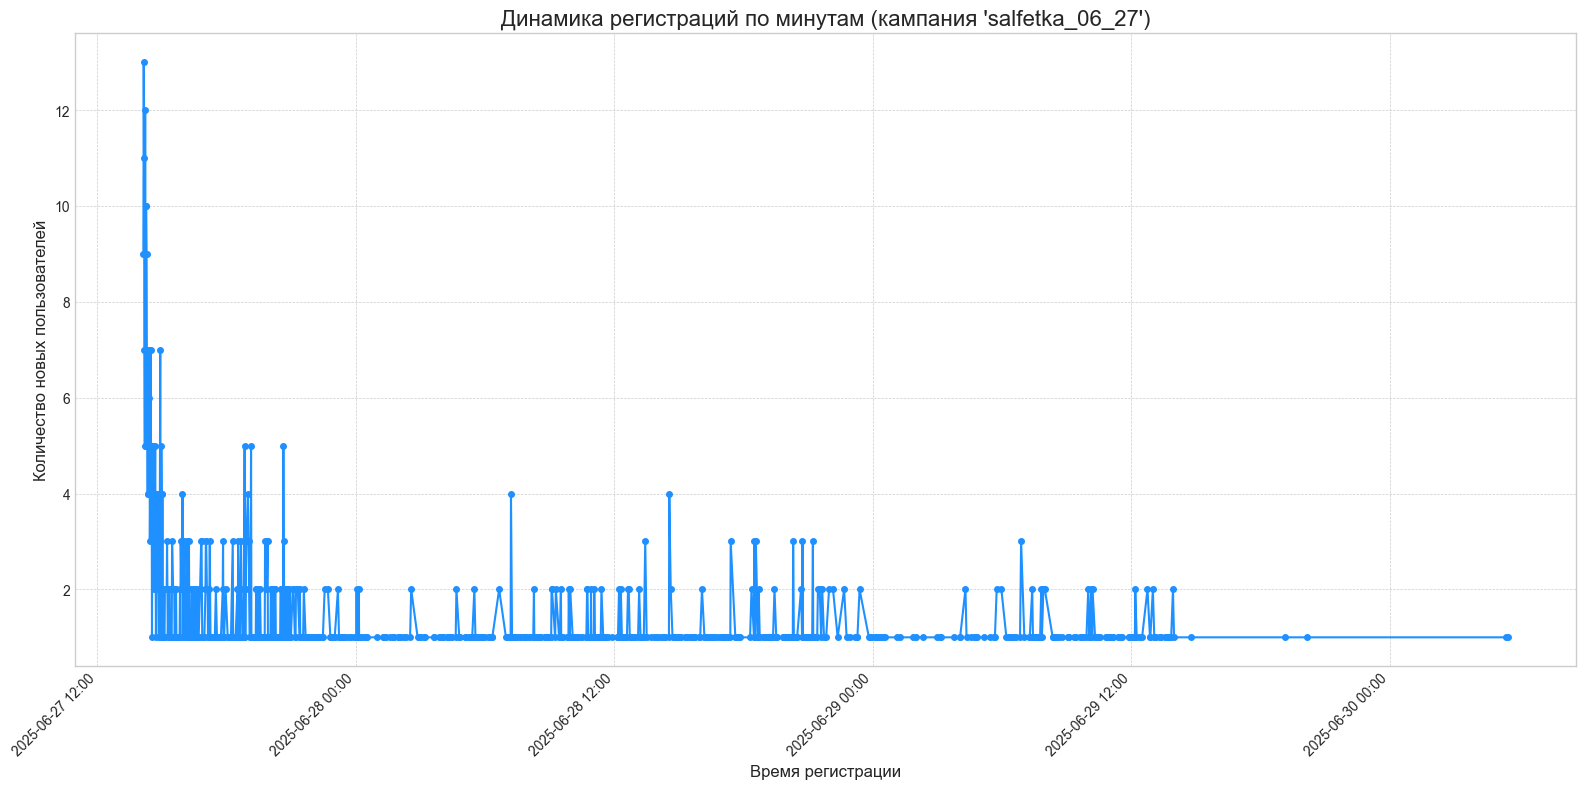


--- Дополнительный анализ: ID пользователей, совершивших покупку ---
Найдено 6 оплативших пользователей.

*. Собираем заказы для 6 пользователей (опционально)...


e:\py_projects\tg_bot\venv\Lib\site-packages\google\cloud\firestore_v1\base_collection.py:303: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


✓ Собрано заказов: 20

--- Детали заказов для оплативших пользователей (первые 5) ---
      user_id   status currency  \
0  1707199753  pending      RUB   
1  5094173429  pending      RUB   
2  5094173429  pending      RUB   
3  5094173429  pending      RUB   
4  5094173429  pending      RUB   

                                             pay_url  \
0  https://pay.strpay.online/?id=2e968e7b-b3c1-46...   
1  https://pay.strpay.online/?id=875914fd-466e-45...   
2  https://pay.strpay.online/?id=ec27cf76-e937-44...   
3  https://pay.strpay.online/?id=0d1012af-23df-4a...   
4  https://pay.strpay.online/?id=70c6a999-b615-48...   

                            external_id  amount  \
0  order_1707199753_1751054807_3534b709     300   
1  order_5094173429_1751057367_d75b8cf5     300   
2  order_5094173429_1751057490_925251db     300   
3  order_5094173429_1751059632_60e89f17     300   
4  order_5094173429_1751059727_de1ad79f     300   

                             invoice_id                    

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from google.cloud import firestore

# --- НАСТРОЙКИ ---
# ID вашего проекта в Google Cloud
GCP_PROJECT_ID = 'tg-bot-clotheoff-prod'
# Имя вашей базы данных Firestore ('(default)' если по умолчанию)
FIRESTORE_DB_NAME = 'undress-tg-bot-prod'

# Названия событий для каждого этапа воронки
EVENT_GENERATION_ATTEMPT_NO_BALANCE = 'generation_attempt_insufficient_balance'
EVENT_VIEW_OFFER = 'payment_package_selected'
EVENT_PAYMENT_SUCCESS = 'payment_successful'
EVENT_GENERATION_SUCCESS_POST_PAYMENT = 'generation_requested' # Успешная генерация после оплаты


def initialize_firestore(project_id, db_name):
    """Инициализирует и проверяет подключение к Firestore."""
    print("Попытка подключения к Firestore...")
    try:
        db = firestore.Client(project=project_id, database=db_name)
        # Простая проверка соединения
        db.collection('users').limit(1).stream()
        print(f"✓ Успешное подключение к проекту '{project_id}' и базе '{db_name}'.")
        return db
    except Exception as e:
        print(f"✗ Ошибка подключения к Firestore. Проверьте аутентификацию ('gcloud auth application-default login').")
        print(f"  Детали ошибки: {e}")
        return None

def get_users_by_source(db_client, source_campaign):
    """
    Получает пользователей из указанной рекламной кампании.
    Возвращает DataFrame pandas.
    """
    print(f"\n1. Ищем пользователей из кампании '{source_campaign}'...")
    users_ref = db_client.collection('users')
    query = users_ref.where('source', '==', source_campaign)
    
    users_data = [doc.to_dict() for doc in query.stream()]
    
    if not users_data:
        print(f"Не найдено ни одного пользователя из кампании '{source_campaign}'.")
        return pd.DataFrame()

    df = pd.DataFrame(users_data)
    # Выбираем и переименовываем нужные колонки для удобства
    df = df[['user_id', 'created_at']].copy()
    print(f"✓ Найдено пользователей: {len(df)}")
    return df

def _fetch_data_for_users_in_chunks(db_client, collection_name, user_ids):
    """
    Вспомогательная функция для эффективной загрузки данных (событий/заказов) 
    для списка пользователей, обходя ограничение Firestore на 30 элементов в запросе 'in'.
    """
    all_data = []
    # Firestore 'in' query supports up to 30 elements
    chunk_size = 30
    user_id_list = list(user_ids) # Преобразуем set в list для срезов

    for i in range(0, len(user_id_list), chunk_size):
        chunk = user_id_list[i:i + chunk_size]
        query = db_client.collection(collection_name).where('user_id', 'in', chunk)
        docs = query.stream()
        all_data.extend([doc.to_dict() for doc in docs])
        
    return pd.DataFrame(all_data)


def get_events_for_users(db_client, user_ids):
    """
    Эффективно получает ВСЕ события для заданного списка user_id.
    """
    print(f"\n2. Собираем события для {len(user_ids)} пользователей...")
    if not user_ids:
        return pd.DataFrame()
    
    df_events = _fetch_data_for_users_in_chunks(db_client, 'user_events', user_ids)
    
    # Убедимся, что event_type не вложен в event_details
    if 'event_type' not in df_events.columns:
        print("Предупреждение: колонка 'event_type' не найдена. Проверьте структуру событий.")
        return pd.DataFrame()
        
    print(f"✓ Собрано релевантных событий: {len(df_events)}")
    return df_events

def get_orders_for_users(db_client, user_ids):
    """
    Эффективно получает ВСЕ заказы для заданного списка user_id.
    """
    print(f"\n*. Собираем заказы для {len(user_ids)} пользователей (опционально)...")
    if not user_ids:
        return pd.DataFrame()
        
    df_orders = _fetch_data_for_users_in_chunks(db_client, 'payment_orders', user_ids)
    
    print(f"✓ Собрано заказов: {len(df_orders)}")
    return df_orders

def analyze_corrected_funnel(df_users, df_events):
    """
    Анализирует воронку в соответствии с исправленной логикой.
    Возвращает словарь с результатами анализа.
    """
    print("\n3. Анализируем воронку и считаем конверсии...")
    
    # Начальные данные
    registered_users = set(df_users['user_id'])
    
    # Инициализируем сеты для каждого этапа
    attempted_gen_no_balance = set()
    viewed_offer = set()
    paid = set()
    used_generation_post_payment = set()
    
    # Заполняем сеты, итерируясь по событиям
    # 使用 .itertuples() для быстрой итерации
    for event in df_events.itertuples():
        user_id = event.user_id
        event_type = event.event_type

        if event_type == EVENT_GENERATION_ATTEMPT_NO_BALANCE:
            attempted_gen_no_balance.add(user_id)
        elif event_type == EVENT_VIEW_OFFER:
            viewed_offer.add(user_id)
        elif event_type == EVENT_PAYMENT_SUCCESS:
            paid.add(user_id)
        elif event_type == EVENT_GENERATION_SUCCESS_POST_PAYMENT:
            used_generation_post_payment.add(user_id)
            
    # Собираем все результаты в один словарь
    funnel_data = {
        'total_users': len(registered_users),
        'attempted_gen_no_balance': len(attempted_gen_no_balance),
        'viewed_offer': len(viewed_offer),
        'paid': len(paid),
        'used_generation_post_payment': len(used_generation_post_payment),
        'ids': { # Сохраняем ID для возможного дальнейшего анализа
            'total': registered_users,
            'attempted': attempted_gen_no_balance,
            'viewed': viewed_offer,
            'paid': paid,
            'used': used_generation_post_payment
        }
    }
    return funnel_data


def display_funnel_report(funnel_data, campaign_name):
    """Красиво выводит отчет по воронке в консоль."""
    # Извлекаем данные для удобства
    total = funnel_data['total_users']
    attempted = funnel_data['attempted_gen_no_balance']
    viewed = funnel_data['viewed_offer']
    paid = funnel_data['paid']
    used = funnel_data['used_generation_post_payment']

    # Расчет конверсий
    cr_reg_to_attempt = (attempted / total * 100) if total > 0 else 0
    cr_attempt_to_view = (viewed / attempted * 100) if attempted > 0 else 0
    cr_view_to_paid = (paid / viewed * 100) if viewed > 0 else 0
    cr_paid_to_use = (used / paid * 100) if paid > 0 else 0
    cr_total_to_paid = (paid / total * 100) if total > 0 else 0

    print("\n" + "="*60)
    print(f"--- Отчет по воронке для кампании '{campaign_name}' ---")
    print("="*60 + "\n")
    print(f"1. Зарегистрировались:\t\t{total} пользователей (100%)")
    print(f"2. Попытка генерации (без баланса):\t{attempted} пользователей")
    print(f"3. Просмотр оффера:\t\t{viewed} пользователей")
    print(f"4. Успешная оплата:\t\t\t{paid} пользователей")
    print(f"5. Использовали генерацию после оплаты:\t{used} пользователей")
    print("\n" + "-"*60)
    print("--- КОНВЕРСИИ ---")
    print("-" * 60 + "\n")
    print(f"CR (Регистрация -> Попытка генерации):\t{cr_reg_to_attempt:.2f}%")
    print(f"CR (Попытка -> Просмотр оффера):\t\t{cr_attempt_to_view:.2f}%")
    print(f"CR (Просмотр оффера -> Оплата):\t\t{cr_view_to_paid:.2f}%")
    print(f"CR (Оплата -> Использование):\t\t{cr_paid_to_use:.2f}%")
    print("-" * 30)
    print(f"CR (Общая: Регистрация -> Оплата):\t{cr_total_to_paid:.2f}%")
    print("\n" + "="*60)


def plot_user_registrations(df_users, campaign_name):
    """Строит и показывает график динамики регистраций."""
    print("\n4. Готовим график регистрации пользователей...")
    df_users['created_at'] = pd.to_datetime(df_users['created_at'])
    df_users['registration_minute'] = df_users['created_at'].dt.floor('T')
    minute_registrations = df_users.groupby('registration_minute').size()

    if minute_registrations.empty:
        print("Недостаточно данных для построения графика.")
        return

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 8))
    minute_registrations.plot(kind='line', ax=ax, color='dodgerblue', marker='o', linestyle='-', ms=4)
    ax.set_title(f"Динамика регистраций по минутам (кампания '{campaign_name}')", fontsize=16)
    ax.set_xlabel("Время регистрации", fontsize=12)
    ax.set_ylabel("Количество новых пользователей", fontsize=12)
    ax.grid(True, which='major', linestyle='--', linewidth=0.5)
    formatter = mdates.DateFormatter('%Y-%m-%d %H:%M')
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    print("✓ График готов. Показываю...")
    plt.show()


if __name__ == "__main__":
    # Укажите здесь название рекламной кампании для анализа
    TARGET_SOURCE = "salfetka_06_27"

    # 1. Подключаемся к базе
    db = initialize_firestore(GCP_PROJECT_ID, FIRESTORE_DB_NAME)

    if db:
        # 2. Получаем пользователей для целевой кампании
        df_campaign_users = get_users_by_source(db, TARGET_SOURCE)
        
        if not df_campaign_users.empty:
            # 3. Собираем все события для этих пользователей
            campaign_user_ids = set(df_campaign_users['user_id'])
            df_campaign_events = get_events_for_users(db, campaign_user_ids)
            
            # 4. Анализируем воронку
            funnel_results = analyze_corrected_funnel(df_campaign_users, df_campaign_events)
            
            # 5. Выводим отчет
            display_funnel_report(funnel_results, TARGET_SOURCE)
            
            # 6. Строим график
            plot_user_registrations(df_campaign_users, TARGET_SOURCE)

            # ----- ПРИМЕРЫ ИСПОЛЬЗОВАНИЯ ФУНКЦИЙ ДЛЯ ДРУГИХ ЗАДАЧ -----
            # Вы можете вызывать эти функции отдельно в ячейках вашего ноутбука
            
            # Пример 1: Получить список всех, кто совершил покупку из этой кампании
            print("\n--- Дополнительный анализ: ID пользователей, совершивших покупку ---")
            paid_user_ids = funnel_results['ids']['paid']
            print(f"Найдено {len(paid_user_ids)} оплативших пользователей.")
            # print(paid_user_ids) # Раскомментируйте, чтобы увидеть ID

            # Пример 2: Получить детали заказов для оплативших пользователей
            if paid_user_ids:
                df_orders_for_paid_users = get_orders_for_users(db, paid_user_ids)
                # Показать первые 5 заказов
                print("\n--- Детали заказов для оплативших пользователей (первые 5) ---")
                print(df_orders_for_paid_users.head())

In [49]:
all_orders = get_orders_for_users(db, campaign_user_ids)


*. Собираем заказы для 1188 пользователей (опционально)...


e:\py_projects\tg_bot\venv\Lib\site-packages\google\cloud\firestore_v1\base_collection.py:303: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


✓ Собрано заказов: 107


In [55]:
my_orders = get_orders_for_users(db, {818053457})


*. Собираем заказы для 1 пользователей (опционально)...
✓ Собрано заказов: 13


e:\py_projects\tg_bot\venv\Lib\site-packages\google\cloud\firestore_v1\base_collection.py:303: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


In [58]:
all_orders[all_orders['user_id'] == 5810366328]

,user_id,status,currency,pay_url,external_id,amount,invoice_id,created_at,package_id,photos_count,method,telegram_payment_charge_id,updated_at,provider_payment_charge_id
91,5810366328,pending,RUB,https://pay.strpay.online/?id=a89af196-34f9-46...,order_5810366328_1751312580_f7c2fb7e,300,a89af196-34f9-462a-8d05-aa4c807859db,2025-06-30 19:43:00.256926+00:00,starter,5,NaN,NaN,NaT,NaN
92,5810366328,pending,RUB,https://pay.strpay.online/?id=84b6d55a-6a82-48...,order_5810366328_1751312652_0918f51b,300,84b6d55a-6a82-48da-860d-4c39a3c5e503,2025-06-30 19:44:12.610485+00:00,starter,5,NaN,NaN,NaT,NaN
93,5810366328,pending,RUB,https://pay.strpay.online/?id=98cbb5ac-e91a-42...,order_5810366328_1751313308_23a8795c,300,98cbb5ac-e91a-42e6-bb82-413c7b20c11b,2025-06-30 19:55:08.849344+00:00,starter,5,NaN,NaN,NaT,NaN
94,5810366328,pending,RUB,https://pay.strpay.online/?id=3e9840be-a0e5-48...,order_5810366328_1751313362_c9f237b5,300,3e9840be-a0e5-48e7-9277-fb9d21208098,2025-06-30 19:56:02.808505+00:00,starter,5,NaN,NaN,NaT,NaN
95,5810366328,pending,RUB,https://pay.strpay.online/?id=b31ce267-f595-43...,order_5810366328_1751313683_c311a6b5,300,b31ce267-f595-4339-b6a9-785e1c5c4b4d,2025-06-30 20:01:23.725230+00:00,starter,5,NaN,NaN,NaT,NaN
96,5810366328,pending,RUB,https://pay.strpay.online/?id=4cf2e7ae-43cb-41...,order_5810366328_1751314291_1cc7e1a8,300,4cf2e7ae-43cb-4182-bd59-c149d2009872,2025-06-30 20:11:31.778105+00:00,starter,5,NaN,NaN,NaT,NaN
97,5810366328,pending,XTR,None,tgstars_5810366328_starter_ca0acdeb,220,None,2025-06-30 19:43:28.902553+00:00,starter,5,tgstars,NaN,NaT,NaN
98,5810366328,success,XTR,None,tgstars_5810366328_starter_db93d6f9,220,None,2025-06-30 20:12:00.368527+00:00,starter,5,tgstars,stxiXFuqcI7SHpCH3YKs_D0W-yAHkKpgLJ3fIjZtRZ9saG...,2025-06-30 20:13:11.110599+00:00,5810366328_1


In [56]:
my_orders

,user_id,status,currency,pay_url,external_id,amount,invoice_id,updated_at,processed,created_at,photos_count,package_id,method
0,818053457,success,RUB,https://pay.streampay.org/?id=68a79c06-c04d-4f...,order_818053457_1749052889_2ca40797,300,68a79c06-c04d-4f2b-9f1e-8240de020f59,2025-06-04 16:02:43.323697+00:00,True,2025-06-04 16:01:29.654955+00:00,5,starter,NaN
1,818053457,pending,RUB,https://pay.streampay.org/?id=86fef10f-2e69-46...,order_818053457_1749660432_02888926,300,86fef10f-2e69-4611-83b9-281f1051b69b,NaT,NaN,2025-06-11 16:47:12.904162+00:00,5,starter,NaN
2,818053457,pending,RUB,https://pay.streampay.org/?id=d1d26774-66fc-4f...,order_818053457_1749660608_3144fb3b,719,d1d26774-66fc-4f91-bdce-b1cc60c2ea11,NaT,NaN,2025-06-11 16:50:08.181007+00:00,15,basic,NaN
3,818053457,pending,RUB,https://pay.streampay.org/?id=31ae5cd4-c738-4e...,order_818053457_1749731605_3f92759e,300,31ae5cd4-c738-4eaa-b939-b5048b777d92,NaT,NaN,2025-06-12 12:33:25.234789+00:00,5,starter,NaN
4,818053457,pending,RUB,https://pay.streampay.org/?id=56e3442e-acca-46...,order_818053457_1749760321_e95edc53,300,56e3442e-acca-4604-8b10-bb025af0a16e,NaT,NaN,2025-06-12 20:32:01.311306+00:00,5,starter,NaN
5,818053457,cancel,RUB,https://pay.streampay.org/?id=e11f6484-9ee2-4d...,order_818053457_1749760332_c25f57a1,719,e11f6484-9ee2-4df0-8dff-e9abef54adcf,2025-06-12 20:47:46.177610+00:00,NaN,2025-06-12 20:32:12.446592+00:00,15,basic,NaN
6,818053457,pending,RUB,https://pay.strpay.online/?id=f4ea57f9-f922-4c...,order_818053457_1750943881_88d6e727,300,f4ea57f9-f922-4c78-ac5e-460541de0d51,NaT,NaN,2025-06-26 13:18:02.118398+00:00,5,starter,NaN
7,818053457,pending,XTR,None,tgstars_818053457_basic_e37b3831,338,None,NaT,NaN,2025-06-27 14:34:35.587248+00:00,15,basic,tgstars
8,818053457,pending,XTR,None,tgstars_818053457_premium_1d9e88cd,1322,None,NaT,NaN,2025-06-27 14:30:02.320191+00:00,50,premium,tgstars
9,818053457,pending,XTR,None,tgstars_818053457_premium_f8cc81f8,1322,None,NaT,NaN,2025-06-27 14:34:45.950067+00:00,50,premium,tgstars


In [54]:
all_orders[all_orders['status'] == 'success']

,user_id,status,currency,pay_url,external_id,amount,invoice_id,created_at,package_id,photos_count,method,telegram_payment_charge_id,updated_at,provider_payment_charge_id
16,6444943650,success,XTR,None,tgstars_6444943650_starter_acd3ab23,220,None,2025-06-27 22:21:16.004725+00:00,starter,5,tgstars,stxcvQ0eeGQyHvGEU-ehv1vWY1URWK2b16qsfIn-zW2MO3...,2025-06-27 22:22:05.652003+00:00,6444943650_2
17,827234586,success,XTR,None,tgstars_827234586_starter_0cbede04,220,None,2025-06-27 19:01:24.139208+00:00,starter,5,tgstars,stxLEDJfo0P_lHg1JJWOnGyoKCF6MtX-41hH8NnrUjuzBm...,2025-06-27 19:04:00.741961+00:00,827234586_24
44,5094173429,success,XTR,None,tgstars_5094173429_starter_9c3509d0,220,None,2025-06-27 21:29:10.889514+00:00,starter,5,tgstars,stx0WXRnIAYVC2bDP0zk96JmiLcB0e04ZQQHG1HokSn7KH...,2025-06-27 21:31:05.347025+00:00,5094173429_1
51,1384997898,success,XTR,None,tgstars_1384997898_starter_e2daa90e,220,None,2025-06-27 20:29:35.964404+00:00,starter,5,tgstars,stxX37Frc_zVbIdR0nAOVL_tBCu1KpYbKcfJdNL-2Fyp_o...,2025-06-27 20:30:15.517514+00:00,1384997898_1
60,1707199753,success,XTR,None,tgstars_1707199753_starter_bd2dd247,220,None,2025-06-27 20:07:18.254806+00:00,starter,5,tgstars,stxtMA1C3FsCj9Ojndfo_lA0Dpn8UUH3Xpx8u_H91E9B0g...,2025-06-27 20:07:52.020042+00:00,1707199753_1
61,1707199753,success,XTR,None,tgstars_1707199753_starter_d1f3b48b,220,None,2025-06-28 19:18:41.683915+00:00,starter,5,tgstars,stx6W1gODJbdxdcfgwWVBOb-wrsSZypOFg4NIW0WPWI0Oq...,2025-06-28 19:19:08.411275+00:00,1707199753_3
98,5810366328,success,XTR,None,tgstars_5810366328_starter_db93d6f9,220,None,2025-06-30 20:12:00.368527+00:00,starter,5,tgstars,stxiXFuqcI7SHpCH3YKs_D0W-yAHkKpgLJ3fIjZtRZ9saG...,2025-06-30 20:13:11.110599+00:00,5810366328_1


In [53]:
all_orders['status'].unique()

array(['pending', 'success'], dtype=object)

In [46]:
1814655541 in campaign_user_ids

True

In [48]:
1814655541 in paid_user_ids

False

In [ ]:
1814655541 - заказал 5 начислил 10

7622366857 - заказал 15

5810366328 - заказал 5  

In [59]:
paid_user_ids

{827234586, 1384997898, 1707199753, 5094173429, 5810366328, 6444943650}

In [43]:
df_orders_for_paid_users[~df_orders_for_paid_users['pay_url'].isna()].status.unique()

array(['pending'], dtype=object)

In [32]:
df_campaign_events[df_campaign_events['event_type'] == 'payment_successful']

,event_details,user_id,event_type,timestamp
137,"{'new_balance_after_payment': 5, 'package_name...",827234586,payment_successful,2025-06-27 19:04:01.040000+00:00
173,"{'new_balance_after_payment': 5, 'package_name...",6444943650,payment_successful,2025-06-27 22:22:05.940000+00:00
415,"{'new_balance_after_payment': 5, 'package_name...",5094173429,payment_successful,2025-06-27 21:31:05.543000+00:00
562,"{'new_balance_after_payment': 5, 'package_name...",1384997898,payment_successful,2025-06-27 20:30:15.728000+00:00
681,"{'new_balance_after_payment': 5, 'package_name...",1707199753,payment_successful,2025-06-27 20:07:52.245000+00:00
688,"{'new_balance_after_payment': 5, 'package_name...",1707199753,payment_successful,2025-06-28 19:19:08.681000+00:00
993,"{'new_balance_after_payment': 5, 'package_name...",5810366328,payment_successful,2025-06-30 20:13:11.382000+00:00


In [33]:
paid_user_ids

{827234586, 1384997898, 1707199753, 5094173429, 5810366328, 6444943650}

In [25]:
funnel_results['ids']['paid']

{'total_users': 1188,
 'attempted_gen_no_balance': 687,
 'viewed_offer': 165,
 'paid': 6,
 'used_generation_post_payment': 6,
 'ids': {'total': {851601411,
   6236565509,
   5124347917,
   930428941,
   418318354,
   847599635,
   2022899732,
   1487527957,
   1395165208,
   7349461017,
   6414594074,
   5355954204,
   1698797597,
   5058443294,
   6762190879,
   5838446624,
   892553246,
   5913784359,
   5503049768,
   6630737960,
   1062402090,
   6291447852,
   7783940142,
   663767087,
   6098653233,
   5624088630,
   6636343350,
   1216012344,
   491851832,
   6630271033,
   5105430587,
   6627987515,
   7408201786,
   6259122238,
   7561619516,
   7687874615,
   7119935554,
   5281978435,
   5221777477,
   2023815238,
   1814902859,
   5811617868,
   6775320653,
   1722003534,
   442802255,
   7610886227,
   5284565076,
   5546586197,
   5022124121,
   5897805913,
   5289003099,
   1167638620,
   5999132765,
   1646473310,
   6769762397,
   5840361578,
   5248245868,
   75902342

In [22]:
df_orders_for_paid_users[(df_orders_for_paid_users['status'] == 'success') ]

,user_id,status,currency,pay_url,external_id,amount,invoice_id,created_at,package_id,photos_count,telegram_payment_charge_id,updated_at,method,provider_payment_charge_id
11,1384997898,success,XTR,None,tgstars_1384997898_starter_e2daa90e,220,None,2025-06-27 20:29:35.964404+00:00,starter,5,stxX37Frc_zVbIdR0nAOVL_tBCu1KpYbKcfJdNL-2Fyp_o...,2025-06-27 20:30:15.517514+00:00,tgstars,1384997898_1
12,1707199753,success,XTR,None,tgstars_1707199753_starter_bd2dd247,220,None,2025-06-27 20:07:18.254806+00:00,starter,5,stxtMA1C3FsCj9Ojndfo_lA0Dpn8UUH3Xpx8u_H91E9B0g...,2025-06-27 20:07:52.020042+00:00,tgstars,1707199753_1
13,1707199753,success,XTR,None,tgstars_1707199753_starter_d1f3b48b,220,None,2025-06-28 19:18:41.683915+00:00,starter,5,stx6W1gODJbdxdcfgwWVBOb-wrsSZypOFg4NIW0WPWI0Oq...,2025-06-28 19:19:08.411275+00:00,tgstars,1707199753_3
14,5094173429,success,XTR,None,tgstars_5094173429_starter_9c3509d0,220,None,2025-06-27 21:29:10.889514+00:00,starter,5,stx0WXRnIAYVC2bDP0zk96JmiLcB0e04ZQQHG1HokSn7KH...,2025-06-27 21:31:05.347025+00:00,tgstars,5094173429_1
16,5810366328,success,XTR,None,tgstars_5810366328_starter_db93d6f9,220,None,2025-06-30 20:12:00.368527+00:00,starter,5,stxiXFuqcI7SHpCH3YKs_D0W-yAHkKpgLJ3fIjZtRZ9saG...,2025-06-30 20:13:11.110599+00:00,tgstars,5810366328_1
18,6444943650,success,XTR,None,tgstars_6444943650_starter_acd3ab23,220,None,2025-06-27 22:21:16.004725+00:00,starter,5,stxcvQ0eeGQyHvGEU-ehv1vWY1URWK2b16qsfIn-zW2MO3...,2025-06-27 22:22:05.652003+00:00,tgstars,6444943650_2
19,827234586,success,XTR,None,tgstars_827234586_starter_0cbede04,220,None,2025-06-27 19:01:24.139208+00:00,starter,5,stxLEDJfo0P_lHg1JJWOnGyoKCF6MtX-41hH8NnrUjuzBm...,2025-06-27 19:04:00.741961+00:00,tgstars,827234586_24


In [23]:
df_orders_for_paid_users

,user_id,status,currency,pay_url,external_id,amount,invoice_id,created_at,package_id,photos_count,telegram_payment_charge_id,updated_at,method,provider_payment_charge_id
0,1707199753,pending,RUB,https://pay.strpay.online/?id=2e968e7b-b3c1-46...,order_1707199753_1751054807_3534b709,300,2e968e7b-b3c1-46d7-a6c2-1110eec14ce1,2025-06-27 20:06:47.117752+00:00,starter,5,NaN,NaT,NaN,NaN
1,5094173429,pending,RUB,https://pay.strpay.online/?id=875914fd-466e-45...,order_5094173429_1751057367_d75b8cf5,300,875914fd-466e-450d-9944-67abf6c281bf,2025-06-27 20:49:27.968334+00:00,starter,5,NaN,NaT,NaN,NaN
2,5094173429,pending,RUB,https://pay.strpay.online/?id=ec27cf76-e937-44...,order_5094173429_1751057490_925251db,300,ec27cf76-e937-448f-908c-e261e9da10a1,2025-06-27 20:51:30.826628+00:00,starter,5,NaN,NaT,NaN,NaN
3,5094173429,pending,RUB,https://pay.strpay.online/?id=0d1012af-23df-4a...,order_5094173429_1751059632_60e89f17,300,0d1012af-23df-4ab2-8a5f-9d6650b47889,2025-06-27 21:27:12.449994+00:00,starter,5,NaN,NaT,NaN,NaN
4,5094173429,pending,RUB,https://pay.strpay.online/?id=70c6a999-b615-48...,order_5094173429_1751059727_de1ad79f,300,70c6a999-b615-4820-ac91-5391fa0559ee,2025-06-27 21:28:47.425559+00:00,starter,5,NaN,NaT,NaN,NaN
5,5810366328,pending,RUB,https://pay.strpay.online/?id=a89af196-34f9-46...,order_5810366328_1751312580_f7c2fb7e,300,a89af196-34f9-462a-8d05-aa4c807859db,2025-06-30 19:43:00.256926+00:00,starter,5,NaN,NaT,NaN,NaN
6,5810366328,pending,RUB,https://pay.strpay.online/?id=84b6d55a-6a82-48...,order_5810366328_1751312652_0918f51b,300,84b6d55a-6a82-48da-860d-4c39a3c5e503,2025-06-30 19:44:12.610485+00:00,starter,5,NaN,NaT,NaN,NaN
7,5810366328,pending,RUB,https://pay.strpay.online/?id=98cbb5ac-e91a-42...,order_5810366328_1751313308_23a8795c,300,98cbb5ac-e91a-42e6-bb82-413c7b20c11b,2025-06-30 19:55:08.849344+00:00,starter,5,NaN,NaT,NaN,NaN
8,5810366328,pending,RUB,https://pay.strpay.online/?id=3e9840be-a0e5-48...,order_5810366328_1751313362_c9f237b5,300,3e9840be-a0e5-48e7-9277-fb9d21208098,2025-06-30 19:56:02.808505+00:00,starter,5,NaN,NaT,NaN,NaN
9,5810366328,pending,RUB,https://pay.strpay.online/?id=b31ce267-f595-43...,order_5810366328_1751313683_c311a6b5,300,b31ce267-f595-4339-b6a9-785e1c5c4b4d,2025-06-30 20:01:23.725230+00:00,starter,5,NaN,NaT,NaN,NaN


In [15]:
df_orders_for_paid_users[df_orders_for_paid_users['user_id'] == 5094173429]

,user_id,status,currency,pay_url,external_id,amount,invoice_id,created_at,package_id,photos_count,telegram_payment_charge_id,updated_at,method,provider_payment_charge_id
1,5094173429,pending,RUB,https://pay.strpay.online/?id=875914fd-466e-45...,order_5094173429_1751057367_d75b8cf5,300,875914fd-466e-450d-9944-67abf6c281bf,2025-06-27 20:49:27.968334+00:00,starter,5,NaN,NaT,NaN,NaN
2,5094173429,pending,RUB,https://pay.strpay.online/?id=ec27cf76-e937-44...,order_5094173429_1751057490_925251db,300,ec27cf76-e937-448f-908c-e261e9da10a1,2025-06-27 20:51:30.826628+00:00,starter,5,NaN,NaT,NaN,NaN
3,5094173429,pending,RUB,https://pay.strpay.online/?id=0d1012af-23df-4a...,order_5094173429_1751059632_60e89f17,300,0d1012af-23df-4ab2-8a5f-9d6650b47889,2025-06-27 21:27:12.449994+00:00,starter,5,NaN,NaT,NaN,NaN
4,5094173429,pending,RUB,https://pay.strpay.online/?id=70c6a999-b615-48...,order_5094173429_1751059727_de1ad79f,300,70c6a999-b615-4820-ac91-5391fa0559ee,2025-06-27 21:28:47.425559+00:00,starter,5,NaN,NaT,NaN,NaN
14,5094173429,success,XTR,None,tgstars_5094173429_starter_9c3509d0,220,None,2025-06-27 21:29:10.889514+00:00,starter,5,stx0WXRnIAYVC2bDP0zk96JmiLcB0e04ZQQHG1HokSn7KH...,2025-06-27 21:31:05.347025+00:00,tgstars,5094173429_1


In [17]:
df_orders_for_paid_users[df_orders_for_paid_users['user_id'] == 6444943650]

,user_id,status,currency,pay_url,external_id,amount,invoice_id,created_at,package_id,photos_count,telegram_payment_charge_id,updated_at,method,provider_payment_charge_id
17,6444943650,pending,XTR,None,tgstars_6444943650_basic_f411a687,338,None,2025-06-27 22:27:32.393171+00:00,basic,15,NaN,NaT,tgstars,NaN
18,6444943650,success,XTR,None,tgstars_6444943650_starter_acd3ab23,220,None,2025-06-27 22:21:16.004725+00:00,starter,5,stxcvQ0eeGQyHvGEU-ehv1vWY1URWK2b16qsfIn-zW2MO3...,2025-06-27 22:22:05.652003+00:00,tgstars,6444943650_2


In [12]:
paid_user_ids

{827234586, 1384997898, 1707199753, 5094173429, 5810366328, 6444943650}